# Find suitable liquid temperature above glassy onset

To make our job of generating supercooled liquid states easier, lets first find a suitable temperature in these systems where the diffusion coefficient $D$ is between $10^{-1}$ and $10^{-2}$ $\tfrac{\sigma^2}{\tau}$. We expect the Stokes-Einstein relation to hold in this regime, falling apart somewhere below $10^{-2}$ $\tfrac{\sigma^2}{\tau}$.

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, colors
import glob

from typing import Callable, Optional, Union

import hoomd
import gsd.hoomd

import sys
import time
import pickle
import gc

from monk import prep, pair, render

import freud

## Utility functions

In [2]:
class VerifyEquilibrium(hoomd.custom.Action):
    """Computes dynamics to verify equilibration."""

    def __init__(self, k: Optional[float] = None, max_alpha_time: float = 1e2):
        self.last_pos = None
        self.last_image = None
        self.last_tstep = None
        if k is None:
            self.k = 7.14
        else:
            self.k = k
        self.max_alpha_time = max_alpha_time
        self.alphas = []
        self.Ds = []
        self.msds = []
        self.sisfs = []
        self.tsteps = []
    
    def act(self, timestep):
        
        if self.last_pos is None:
            snap = self._state.get_snapshot()
            self.last_pos = snap.particles.position
            self.last_image = snap.particles.image
            self.first_tstep = timestep
            self.last_tstep = timestep
            self.last_msd = 0.0
            self.alpha_time = 0.0
            self.measure_D = False
            self.measured_D = 0.0
            self.measured_alpha = 0.0
        else:
            if self.measure_D:
                dt = self._state._simulation.operations.integrator.dt
                if (timestep - self.last_tstep)*dt > self.measured_alpha:
                    snap = self._state.get_snapshot()
                    pos = snap.particles.position
                    image = snap.particles.image
                    sim_box = self._state.box
                    if sim_box.is2D:
                        dim = 2
                    else:
                        dim = 3
                    box = freud.box.Box.from_box(sim_box)
                    unwrapped_pos = box.unwrap(pos, image - self.last_image)
                    msd = np.mean(np.sum(np.square(unwrapped_pos - self.last_pos), axis=-1))
                    self.msds.append(msd)
                    self.tsteps.append(timestep - self.first_tstep)
                    D = (msd - self.last_msd) / (timestep - self.last_tstep) / dt / (2 * dim)
                    self.measured_D = D
                    self.Ds.append(self.measured_D)
                    self.alphas.append(self.measured_alpha)
                    self.measure_D = False
                    self.alpha_time = 0.0
                    self.first_tstep = timestep
                    self.last_pos = snap.particles.position
                    self.last_image = snap.particles.image
            else:
                snap = self._state.get_snapshot()
                dt = self._state._simulation.operations.integrator.dt
                pos = snap.particles.position
                image = snap.particles.image
                sim_box = self._state.box
                if sim_box.is2D:
                    dim = 2
                else:
                    dim = 3
                box = freud.box.Box.from_box(sim_box)
                unwrapped_pos = box.unwrap(pos, image - self.last_image)
                msd = np.mean(np.sum(np.square(unwrapped_pos - self.last_pos), axis=-1))
                self.msds.append(msd)
                time_diff = timestep - self.first_tstep
                self.tsteps.append(time_diff)
                self.last_tstep = timestep
                self.last_msd = msd

                x = self.k * np.linalg.norm(pos - self.last_pos, axis=-1)
                sisf = np.mean(np.sin(x)/x)
                self.sisfs.append(sisf)

                # print(f"{D} {sisf}")

                self.alpha_time = (timestep - self.first_tstep) * dt
                if sisf < np.exp(-1.0):
                    self.measure_D = True
                    self.measured_alpha = self.alpha_time
                elif self.alpha_time > self.max_alpha_time:
                    raise RuntimeError("Alpha relaxation time is too long.")

## System tests

### KA_LJ

|$\rho$   |$T$      |$D$      |
|---------|---------|---------|
|1.1      |0.8      |0.018    |
|1.1      |1.0      |0.028    |
|1.1      |1.5      |0.055    |
|1.2      |1.0      |0.012    |
|1.2      |1.5      |0.032    |
|1.2      |2.0      |0.053    |
|1.4      |2.0      |0.014    |
|1.4      |2.5      |0.026    |
|1.4      |3.0      |0.040    |
|1.6      |3.5      |0.015    |
|1.6      |4.0      |0.023    |
|1.6      |5.0      |0.041    |

### KA_WCA

|$\rho$   |$T$      |$D$      |
|---------|---------|---------|
|1.1      |0.7      |0.022    |
|1.1      |1.0      |0.039    |
|1.1      |1.3      |0.055    |
|1.2      |1.0      |0.019    |
|1.2      |1.5      |0.039    |
|1.2      |2.0      |0.061    |
|1.4      |2.0      |0.017    |
|1.4      |2.5      |0.030    |
|1.4      |3.0      |0.043    |
|1.6      |3.5      |0.016    |
|1.6      |4.0      |0.024    |
|1.6      |5.0      |0.042    |

### KA_WLJ $\epsilon_{attr}=0.5$

|$\rho$   |$T$      |$D$      |
|---------|---------|---------|
|1.1      |0.8      |0.022    |
|1.1      |1.0      |0.033    |
|1.1      |1.3      |0.051    |
|1.2      |1.0      |0.015    |
|1.2      |1.5      |0.035    |
|1.2      |2.0      |0.058    |
|1.4      |2.0      |0.016    |
|1.4      |2.5      |0.028    |
|1.4      |3.0      |0.041    |
|1.6      |3.5      |0.016    |
|1.6      |4.0      |0.024    |
|1.6      |5.0      |0.042    |

### KA_MLJ $\Delta=0.4$

|$\rho$   |$T$      |$D$      |
|---------|---------|---------|
|1.1      |2.0      |0.005    |
|1.1      |3.0      |0.017    |
|1.1      |4.0      |0.031    |
|1.2      |4.0      |0.005    |
|1.2      |6.0      |0.021    |
|1.2      |8.0      |0.040    |
|1.3      |10.0     |0.018    |
|1.3      |12.0     |0.030    |
|1.3      |14.0     |0.043    |
|1.4      |12.0     |0.003    |
|1.4      |16.0     |0.015    |
|1.4      |20.0     |0.031    |

### KA_MLJ $\Delta=0.2$

|$\rho$   |$T$      |$D$      |
|---------|---------|---------|
|1.1      |1.5      |0.021    |
|1.1      |2.0      |0.037    |
|1.1      |5.0      |0.132    |
|1.2      |2.0      |0.014    |
|1.2      |2.5      |0.024    |
|1.2      |3.5      |0.048    |
|1.3      |3.5      |0.020    |
|1.3      |4.5      |0.037    |
|1.3      |5.5      |0.057    |
|1.4      |5.5      |0.025    |
|1.4      |6.5      |0.038    |
|1.4      |7.5      |0.050    |
|1.6      |7.5      |0.006    |
|1.6      |10.0     |0.020    |
|1.6      |15.0     |0.060    |

### Wahn equal masses

|$\rho$   |$T$      |$D$      |
|---------|---------|---------|
|1.0      |4.0      |0.009    |
|1.0      |4.5      |0.037    |
|1.0      |5.0      |0.049    |
|1.2      |6.0      |0.006    |
|1.2      |8.0      |0.026    |
|1.2      |9.0      |0.038    |
|1.4      |15.0     |0.031    |

## Workspace

In [22]:
N = 2**14
rho = 1.2
device = hoomd.device.GPU()

temperature = 1.0
dt = 0.005
tau = dt*100
step_unit = int(1/dt)
run_time = 1
run_steps = int(run_time*step_unit)
equil_time = 40
equil_steps = int(equil_time*step_unit)
alpha_iters = 5
relax_time = 40
relax_steps = int(relax_time*step_unit)

sim = prep.quick_sim(N, rho, device, dim=2, ratios=[60, 40], diams=[1.0, 0.88])

integrator = hoomd.md.Integrator(dt=dt)
tree = hoomd.md.nlist.Tree(0.3)
potential = pair.KA_LJ(tree)
nvt = hoomd.md.methods.NVT(hoomd.filter.All(), temperature, tau)
integrator.forces = [potential]
integrator.methods = [nvt]

sim.operations.integrator = integrator

analyzer = hoomd.md.compute.ThermodynamicQuantities(hoomd.filter.All())
sim.operations.computes.append(analyzer)

sim.run(0)

thermodynamic_quantities = hoomd.md.compute.ThermodynamicQuantities(hoomd.filter.All())
sim.operations.computes.append(thermodynamic_quantities)

sim.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=temperature)
nvt.thermalize_thermostat_dof()

print("System created")

sim.run(equil_steps)

print("Equilibration finished")

action = VerifyEquilibrium(max_alpha_time=10)
custom_action = hoomd.update.CustomUpdater(hoomd.trigger.Periodic(run_steps), action)
sim.operations.updaters.clear()
sim.operations.updaters.append(custom_action)

writer = hoomd.write.GSD(filename="test.gsd", trigger=hoomd.trigger.Periodic(run_steps), mode="wb")
sim.operations.writers.clear()
sim.operations.writers.append(writer)

n = len(action.alphas)
while len(action.alphas) < alpha_iters:
    sim.run(run_steps)
    sim.always_compute_pressure = True
    if len(action.alphas) > n:
        n = len(action.alphas)
        print("Alpha relaxation times:", action.alphas[-1])
        print("Diffusion coefficients:", action.Ds[-1])
        print("Pressure:", analyzer.pressure)

nvt.kT = 0.1

action = VerifyEquilibrium(max_alpha_time=np.inf)
custom_action = hoomd.update.CustomUpdater(hoomd.trigger.Periodic(run_steps), action)
sim.operations.updaters.clear()
sim.operations.updaters.append(custom_action)

n = len(action.alphas)
while len(action.alphas) < alpha_iters:
    sim.run(run_steps)
    sim.always_compute_pressure = True
    if len(action.alphas) > n:
        n = len(action.alphas)
        print("Alpha relaxation times:", action.alphas[-1])
        print("Diffusion coefficients:", action.Ds[-1])
        print("Pressure:", analyzer.pressure)

print("Alpha relaxation times:", action.alphas)
print("Diffusion coefficients:", action.Ds)

sim.operations.updaters.clear()

therm_snap = sim.state.get_snapshot()

sim.always_compute_pressure = True
sim.run(0)
print("Pressure:", thermodynamic_quantities.pressure)
sim.always_compute_pressure = False
tol = 1e-5
fire = hoomd.md.minimize.FIRE(dt, tol, tol, tol)
sim.operations.integrator = fire
nve = hoomd.md.methods.NVE(hoomd.filter.All())
fire.forces = [potential]
fire.methods = [nve]

while fire.converged == False:
    print(fire.converged)
    sim.run(relax_steps)
sim.always_compute_pressure = True
sim.run(0)
print("Pressure:", thermodynamic_quantities.pressure)
sim.always_compute_pressure = False

snap = sim.state.get_snapshot()

del sim, action, custom_action, integrator, potential, tree, fire, nvt, nve
gc.collect();

System created
Equilibration finished
Alpha relaxation times: 1.9999999552965164
Diffusion coefficients: 0.015451197817382792
Pressure: 11.148860931396484
Alpha relaxation times: 1.9999999552965164
Diffusion coefficients: 0.016294940056077976
Pressure: 11.595805168151855
Alpha relaxation times: 1.9999999552965164
Diffusion coefficients: 0.016450166521645312
Pressure: 10.824978828430176
Alpha relaxation times: 1.9999999552965164
Diffusion coefficients: 0.017056724870954602
Pressure: 11.173006057739258
Alpha relaxation times: 1.9999999552965164
Diffusion coefficients: 0.014399131318114891
Pressure: 11.20807933807373
Alpha relaxation times: 3.999999910593033
Diffusion coefficients: -0.0004131661711705966
Pressure: 1.9191073179244995
Alpha relaxation times: 6.9999998435378075
Diffusion coefficients: 0.0006826887247047574
Pressure: 1.6437911987304688


KeyboardInterrupt: 

In [39]:
N = 2**12
rho = 1.2
device = hoomd.device.GPU()

temperature = 1.0
dt = 0.001
tau = dt*100
step_unit = int(1/dt)
run_time = 10
run_steps = int(run_time*step_unit)
equil_time = 40
equil_steps = int(equil_time*step_unit)
alpha_iters = 5
relax_time = 100
relax_steps = int(relax_time*step_unit)
tol = 1e-2

sim = prep.quick_sim(N, rho, device, dim=2, ratios=[60, 40], diams=[1.0, 0.88])

integrator = hoomd.md.Integrator(dt=dt)
tree = hoomd.md.nlist.Tree(0.3)
potential = pair.KA_LJ(tree)
nvt = hoomd.md.methods.NVT(hoomd.filter.All(), temperature, tau)
integrator.forces = [potential]
integrator.methods = [nvt]

sim.operations.integrator = integrator

sim.run(0)

thermodynamic_quantities = hoomd.md.compute.ThermodynamicQuantities(hoomd.filter.All())
sim.operations.computes.append(thermodynamic_quantities)

sim.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=temperature)
nvt.thermalize_thermostat_dof()

print("System created")

sim.run(equil_steps)

print("Equilibration finished")

action = VerifyEquilibrium()
custom_action = hoomd.update.CustomUpdater(hoomd.trigger.Periodic(run_steps), action)
sim.operations.updaters.clear()
sim.operations.updaters.append(custom_action)

while len(action.alphas) < alpha_iters:
    sim.run(run_steps)

print("Alpha relaxation times:", action.alphas)
print("Diffusion coefficients:", action.Ds)

sim.operations.updaters.clear()

therm_snap = sim.state.get_snapshot()

sim.always_compute_pressure = True
sim.run(0)
print("Pressure:", thermodynamic_quantities.pressure)
sim.always_compute_pressure = False

fire = hoomd.md.minimize.FIRE(dt, tol, tol, 1e-8)
sim.operations.integrator = fire
nve = hoomd.md.methods.NVE(hoomd.filter.All())
fire.forces = [potential]
fire.methods = [nve]

while fire.converged == False:
    print(fire.converged)
    sim.run(relax_steps)
sim.always_compute_pressure = True
sim.run(0)
print("Pressure:", thermodynamic_quantities.pressure)
sim.always_compute_pressure = False

snap = sim.state.get_snapshot()

del sim, action, custom_action, integrator, potential, tree, fire, nvt, nve
gc.collect();

System created
Equilibration finished
Alpha relaxation times: [10.000000474974513, 10.000000474974513, 10.000000474974513, 10.000000474974513, 10.000000474974513]
Diffusion coefficients: [0.0137445118187182, 0.011409507041000546, 0.010407654958372342, 0.011551345208954247, 0.012886843864705254]
Pressure: 10.79077434539795
False
Pressure: 0.668507993221283


In [48]:
N = 2**12
rho = 1.2
device = hoomd.device.GPU()

temperature = 1e-2
dt = 0.001
tau = dt*100
step_unit = int(1/dt)
run_time = 10
run_steps = int(run_time*step_unit)
equil_time = 40
equil_steps = int(equil_time*step_unit)
alpha_iters = 5
relax_time = 40
relax_steps = int(relax_time*step_unit)
tol1 = 1e-6
tol2 = 1e-8

sim = prep.quick_sim(N, rho, device, dim=2, ratios=[50, 50], diams=[14/12, 10/12])

integrator = hoomd.md.Integrator(dt=dt)
tree = hoomd.md.nlist.Tree(0.3)
potential = pair.bi_hertz(tree)
nvt = hoomd.md.methods.NVT(hoomd.filter.All(), temperature, tau)
integrator.forces = [potential]
integrator.methods = [nvt]

sim.operations.integrator = integrator

sim.run(0)

thermodynamic_quantities = hoomd.md.compute.ThermodynamicQuantities(hoomd.filter.All())
sim.operations.computes.append(thermodynamic_quantities)


sim.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=temperature)
nvt.thermalize_thermostat_dof()

print("System created")

sim.run(equil_steps)

print("Equilibration finished")

action = VerifyEquilibrium()
custom_action = hoomd.update.CustomUpdater(hoomd.trigger.Periodic(run_steps), action)
sim.operations.updaters.clear()
sim.operations.updaters.append(custom_action)

while len(action.alphas) < alpha_iters:
    sim.run(run_steps)

print("Alpha relaxation times:", action.alphas)
print("Diffusion coefficients:", action.Ds)

sim.operations.updaters.clear()

therm_snap = sim.state.get_snapshot()

sim.always_compute_pressure = True
sim.run(0)
print("Pressure:", thermodynamic_quantities.pressure)
sim.always_compute_pressure = False

fire = hoomd.md.minimize.FIRE(dt, tol1, tol1, tol2)
sim.operations.integrator = fire
nve = hoomd.md.methods.NVE(hoomd.filter.All())
fire.forces = [potential]
fire.methods = [nve]

while fire.converged == False:
    print(fire.converged)
    sim.run(relax_steps)
sim.always_compute_pressure = True
sim.run(0)
print("Pressure:", thermodynamic_quantities.pressure)
sim.always_compute_pressure = False

snap = sim.state.get_snapshot()

del sim, action, custom_action, integrator, potential, tree, fire, nvt, nve
gc.collect();

System created
Equilibration finished
Alpha relaxation times: [10.000000474974513, 10.000000474974513, 10.000000474974513, 10.000000474974513, 10.000000474974513]
Diffusion coefficients: [0.019195633921502482, 0.01816344556213944, 0.019147287521417113, 0.01892364811250962, 0.018320655928570895]
Pressure: 0.06280533969402313
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


KeyboardInterrupt: 

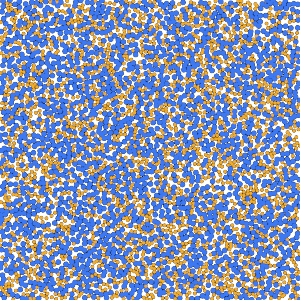

In [46]:
render.render_disk_frame(therm_snap)

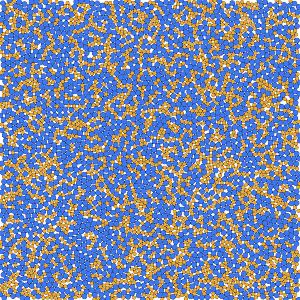

In [47]:
render.render_disk_frame(snap)

In [49]:
unfin_snap = sim.state.get_snapshot()
sim.always_compute_pressure = True
sim.run(0)
print("Pressure:", thermodynamic_quantities.pressure)
sim.always_compute_pressure = False

Pressure: 0.017567317932844162


In [50]:
diff = (unfin_snap.particles.position - snap.particles.position)[:,:2]

In [51]:
pos = snap.particles.position[:,:2]

(array([1113., 1728.,  848.,  293.,   67.,   11.,    2.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]),
 array([ 0.        ,  0.2020202 ,  0.4040404 ,  0.60606061,  0.80808081,
         1.01010101,  1.21212121,  1.41414141,  1.61616162,  1.81818182,
         2.02020202,  2.22222222,  2.42424242,  2.62626263,  2.82828283

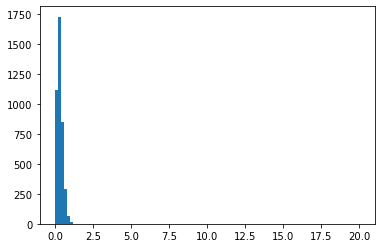

In [52]:
plt.hist(np.linalg.norm(unfin_snap.particles.position - snap.particles.position, axis=-1), bins=np.linspace(0, 20.0, 100))

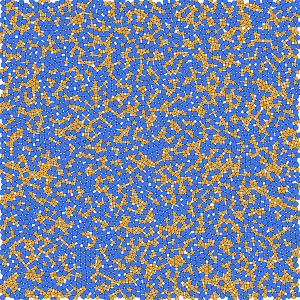

In [53]:
render.render_disk_frame(unfin_snap)

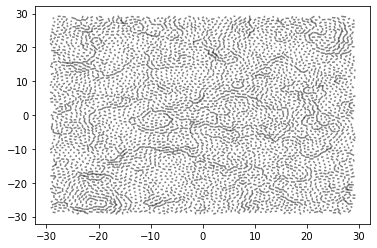

In [54]:
for i in range(len(diff)):
    if np.linalg.norm(diff[i]) > 20:
        continue
    plt.plot([pos[i,0], pos[i,0]+diff[i,0]], [pos[i,1], pos[i,1]+diff[i,1]], color='black', alpha=0.5)